In [1]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import logging
from concurrent.futures import ThreadPoolExecutor

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader as TorchDataLoader
from torch.utils.data import WeightedRandomSampler
import kornia
from PIL import Image

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import seaborn as sns  # For confusion matrix heatmap
from collections import Counter

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------- Data Augmentation (TorchVision) ----------------------------
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ---------------------------- Fingerprint Dataset ----------------------------
class FingerprintDataset(Dataset):
    """
    Holds (image, label) pairs and applies either train_transform or eval_transform.
    """
    def __init__(self, images, labels, is_train=True):
        self.images = images
        self.labels = labels
        self.is_train = is_train
        self.transform = train_transform if is_train else eval_transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        lbl = self.labels[idx]
        img_t = self.transform(img)
        return img_t, lbl

# ---------------------------- Directory Data Loader ----------------------------
class DataLoaderCustom:
    def __init__(self, dataset_dirs, num_threads=8):
        self.dataset_dirs = dataset_dirs
        self.num_threads = num_threads

    def load_dataset(self):
        images = []
        labels = []
        with ThreadPoolExecutor(max_workers=self.num_threads) as executor:
            futures = [executor.submit(self._process_dataset_dir, d) for d in self.dataset_dirs]
            for f in futures:
                sub_imgs, sub_lbls = f.result()
                images.extend(sub_imgs)
                labels.extend(sub_lbls)
        return images, labels

    def extract_label_from_filename(self, filename):
        lower_file = filename.lower()
        for finger in ["thumb", "index", "middle", "ring", "little"]:
            if finger in lower_file:
                return finger.capitalize()
        return None

    def _process_dataset_dir(self, dataset_dir):
        local_images = []
        local_labels = []
        print(f"Processing dataset directory: {dataset_dir}")
        entries = [e for e in os.listdir(dataset_dir) if e.lower() != 'thumbs.db']
        
        if all(not os.path.isdir(os.path.join(dataset_dir, e)) for e in entries):
            # Directory with files only
            for file in entries:
                if file.lower().endswith(('.tif', '.bpm', '.bmp', '.png', '.jpeg', '.jpg')):
                    file_path = os.path.join(dataset_dir, file)
                    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
                    if img is not None:
                        label_extracted = self.extract_label_from_filename(file)
                        if label_extracted is None:
                            label_extracted = os.path.basename(dataset_dir)
                        local_images.append(img)
                        local_labels.append(label_extracted)
                        print(f"  Loaded image: {file} with label: {label_extracted}")
                    else:
                        print(f"  Failed to load image: {file}")
        else:
            # Directory with subfolders
            for label in entries:
                lbl_dir = os.path.join(dataset_dir, label)
                if os.path.isdir(lbl_dir):
                    seen_files = set()
                    for file in os.listdir(lbl_dir):
                        if file.lower().endswith(('.tif', '.bpm', '.bmp', '.png', '.jpeg', '.jpg')):
                            file_path = os.path.join(lbl_dir, file)
                            sz = os.path.getsize(file_path)
                            if sz in seen_files:
                                continue
                            seen_files.add(sz)
                            img = cv2.imread(file_path, cv2.IMREAD_COLOR)
                            if img is not None:
                                local_images.append(img)
                                local_labels.append(label)
                                print(f"  Loaded image: {file} with label: {label}")
                            else:
                                print(f"  Failed to load image: {file}")
                else:
                    print(f"  Skipping non-directory: {label}")
        
        return local_images, local_labels

# ---------------------------- WeightedRandomSampler (Oversampling) ----------------------------
def make_weighted_sampler(labels):
    """
    Oversample the rarer classes (Ring, Middle) by weighting each class
    inversely proportional to its frequency.
    """
    freq = Counter(labels)
    total = len(labels)
    class_weights = {cls: total / freq[cls] for cls in freq}
    sample_weights = [class_weights[lbl] for lbl in labels]
    sampler = WeightedRandomSampler(weights=sample_weights,
                                    num_samples=len(labels),
                                    replacement=True)
    return sampler

# ---------------------------- Vision Transformer + Classical Edge Features ----------------------------
class CombinedModel(nn.Module):
    """
    1) Vision Transformer (vit_b_16) backbone (unfrozen),
    2) Sobel edge detection -> (mean, std),
    3) Concatenate => 768 + 2 = 770 features,
    4) 2-layer MLP to get final num_classes.
    """
    def __init__(self, num_classes=5):
        super().__init__()
        # Load pretrained ViT-B/16
        # Requires torchvision >= 0.13
        vit = models.vit_b_16(weights='IMAGENET1K_V1')  
        # Unfreeze all layers
        for p in vit.parameters():
            p.requires_grad = True

        # Remove final classification head (i.e., set heads to identity)
        # vit_b_16 default heads: Linear(768 -> 1000)
        vit.heads = nn.Identity()

        # So now vit(...) -> [B,768]
        self.vit_backbone = vit

        # MLP for (768 + 2) => 256 => num_classes
        self.classifier = nn.Sequential(
            nn.Linear(770, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # 1) Deep features from ViT (embedding dim=768)
        deep_feat = self.vit_backbone(x)  # shape [B,768]

        # 2) Sobel-based classical features
        # x is normalized [B,3,224,224]. We'll compute grayscale->sobel->(mean,std).
        gray = kornia.color.rgb_to_grayscale(x)
        blurred = kornia.filters.gaussian_blur2d(gray, kernel_size=(5,5), sigma=(1.0,1.0))
        edges = kornia.filters.sobel(blurred)
        edge_map = torch.sqrt(torch.sum(edges**2, dim=1, keepdim=True))  # [B,1,H,W]

        mean_edge = edge_map.view(edge_map.size(0), -1).mean(dim=1) # [B]
        std_edge  = edge_map.view(edge_map.size(0), -1).std(dim=1)  # [B]
        classical_feats = torch.stack([mean_edge, std_edge], dim=1) # [B,2]

        # 3) Concat => shape [B,770]
        fused = torch.cat([deep_feat, classical_feats], dim=1)

        # 4) Classify
        logits = self.classifier(fused)
        return logits

# ---------------------------- Model Trainer ----------------------------
class ModelTrainer:
    def __init__(self, num_classes=5, num_epochs=40, lr=1e-4, batch_size=32):
        self.num_classes = num_classes
        self.num_epochs  = num_epochs
        self.lr          = lr
        self.batch_size  = batch_size

        self.model = CombinedModel(num_classes=num_classes).to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        self.label_to_idx = {}
        self.idx_to_label = {}

    def fit(self, train_images, train_labels, val_images, val_labels):
        """
        Create Datasets & DataLoaders, oversample ring/middle in train, run training for self.num_epochs.
        """
        unique_labels = sorted(list(set(train_labels)))
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        self.idx_to_label = {v: k for k, v in self.label_to_idx.items()}

        train_dataset = FingerprintDataset(train_images, train_labels, is_train=True)
        val_dataset   = FingerprintDataset(val_images,   val_labels,   is_train=False)

        sampler = make_weighted_sampler(train_labels)
        train_loader = TorchDataLoader(train_dataset, batch_size=self.batch_size,
                                       sampler=sampler, drop_last=False)
        val_loader   = TorchDataLoader(val_dataset, batch_size=self.batch_size,
                                       shuffle=False, drop_last=False)

        for epoch in range(self.num_epochs):
            self.model.train()
            total_loss = 0.0
            total_samples = 0
            for batch_x, batch_labels_str in train_loader:
                # Convert textual labels -> numeric
                batch_labels = torch.tensor([self.label_to_idx[lbl] for lbl in batch_labels_str],
                                            dtype=torch.long)
                batch_x = batch_x.to(device)
                batch_labels = batch_labels.to(device)

                self.optimizer.zero_grad()
                logits = self.model(batch_x)
                loss = self.criterion(logits, batch_labels)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item() * batch_x.size(0)
                total_samples += batch_x.size(0)

            avg_loss = total_loss / total_samples
            print(f"Epoch [{epoch+1}/{self.num_epochs}], Loss: {avg_loss:.4f}")
        
        print("Training complete.")

    def evaluate(self, test_images, test_labels):
        """
        Evaluate on test set, printing accuracy & weighted F1.
        """
        test_dataset = FingerprintDataset(test_images, test_labels, is_train=False)
        test_loader = TorchDataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=False)

        self.model.eval()
        all_preds = []
        all_truth = []
        with torch.no_grad():
            for batch_x, batch_lbl_str in test_loader:
                batch_x = batch_x.to(device)
                logits = self.model(batch_x)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_truth.extend(batch_lbl_str)

        # Convert numeric preds => string
        pred_labels_str = [self.idx_to_label[p] for p in all_preds]

        acc = accuracy_score(all_truth, pred_labels_str)
        f1  = f1_score(all_truth, pred_labels_str, average='weighted', zero_division=0)
        print(f"Test Accuracy: {acc:.2f}")
        print(f"Test F1 Score: {f1:.2f}")
        return pred_labels_str

    def predict(self, images_list):
        """
        Single-image or batch inference. images_list is a list of raw cv2 images.
        """
        self.model.eval()
        dummy_labels = ["Unknown"] * len(images_list)
        dataset = FingerprintDataset(images_list, dummy_labels, is_train=False)
        loader  = TorchDataLoader(dataset, batch_size=len(images_list), shuffle=False, drop_last=False)

        with torch.no_grad():
            for batch_x, _ in loader:
                batch_x = batch_x.to(device)
                logits = self.model(batch_x)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                # Convert to textual labels
                pred_labels_str = [self.idx_to_label[p] for p in preds]
                return pred_labels_str, logits.cpu().numpy()

# ---------------------------- Main Pipeline ----------------------------
class Pipeline:
    def __init__(self, dataset_dirs, num_epochs=40, lr=1e-4, batch_size=32):
        self.dataset_dirs = dataset_dirs
        self.num_epochs = num_epochs
        self.lr = lr
        self.batch_size = batch_size

        self.data_loader = DataLoaderCustom(dataset_dirs)
        self.model_trainer = None

        self.y_train = []
        self.y_val   = []
        self.y_test  = []
        self.train_imgs = []
        self.val_imgs   = []
        self.test_imgs  = []

    def run(self):
        images, labels = self.data_loader.load_dataset()
        print(f"Loaded {len(images)} images total.")

        # Train-val-test split
        X_temp, X_test, y_temp, y_test = train_test_split(images, labels,
                                                          test_size=0.15, random_state=42, stratify=labels)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                          test_size=0.1765, random_state=42, stratify=y_temp)

        self.train_imgs = X_train
        self.val_imgs   = X_val
        self.test_imgs  = X_test
        self.y_train    = y_train
        self.y_val      = y_val
        self.y_test     = y_test

        print(f"Training set: {len(X_train)} images, Validation set: {len(X_val)} images, Test set: {len(X_test)} images")

        num_classes = len(set(y_train))
        self.model_trainer = ModelTrainer(num_classes=num_classes,
                                          num_epochs=self.num_epochs,
                                          lr=self.lr,
                                          batch_size=self.batch_size)
        self.model_trainer.fit(X_train, y_train, X_val, y_val)

        # Evaluate
        self.model_trainer.evaluate(X_test, y_test)

# ---------------------------- Helper: Plot Class Distribution ----------------------------
def plot_class_distribution(y_train, y_val, y_test, save_path='class_distribution.png'):
    classes = sorted(list(set(y_train + y_val + y_test)))
    train_counts = [y_train.count(cls) for cls in classes]
    val_counts   = [y_val.count(cls)   for cls in classes]
    test_counts  = [y_test.count(cls)  for cls in classes]

    x = np.arange(len(classes))
    width = 0.25

    plt.figure(figsize=(8, 6))
    plt.bar(x - width, train_counts, width, label='Train')
    plt.bar(x,         val_counts,   width, label='Validation')
    plt.bar(x + width, test_counts,  width, label='Test')

    plt.xlabel('Finger Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution: Train / Validation / Test')
    plt.xticks(x, classes)
    plt.legend()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ---------------------------- Helper: Confusion Matrix & Report ----------------------------
def plot_confusion_matrix_and_report(pipeline, normalize=None, save_path='confusion_matrix.png'):
    test_imgs = pipeline.test_imgs
    test_labels = pipeline.y_test
    trainer = pipeline.model_trainer

    test_dataset = FingerprintDataset(test_imgs, test_labels, is_train=False)
    test_loader = TorchDataLoader(test_dataset, batch_size=trainer.batch_size,
                                  shuffle=False, drop_last=False)

    trainer.model.eval()
    all_preds = []
    all_truth = []
    with torch.no_grad():
        for batch_x, batch_lbl_str in test_loader:
            batch_x = batch_x.to(device)
            logits = trainer.model(batch_x)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_truth.extend(batch_lbl_str)

    class_labels = sorted(list(trainer.label_to_idx.keys()))
    pred_labels_str = [trainer.idx_to_label[p] for p in all_preds]

    cm = confusion_matrix(all_truth, pred_labels_str, labels=class_labels, normalize=normalize)

    print("\nClassification Report:")
    print(classification_report(all_truth, pred_labels_str, labels=class_labels))

    plt.figure(figsize=(8, 6))
    fmt = '.2f' if normalize else 'd'
    sns.heatmap(cm, annot=True, fmt=fmt,
                xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    title_str = "Confusion Matrix"
    if normalize:
        title_str += f" (Normalized: {normalize})"
    plt.title(title_str)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# ---------------------------- Helper: Single Image Inference ----------------------------
def single_image_inference_with_visuals(pipeline, image_path):
    """
    Loads a single image, extracts features using the pipeline's feature extractor,
    applies the pipeline's feature mask (if any), predicts the label,
    AND displays the original vs. processed image side by side.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image from {image_path}")
        return None, None
    
    # (1) Extract fused features, plus the edge map (processed_img) and fingerprint features
    #    Note: process_single_image returns (fused_feat, edge_map, fingerprint_feat)
    fused_feat, edge_map, fingerprint_feat = pipeline.feature_extractor.process_single_image(img)
    
    # (2) Display side-by-side images: Original vs. Edge Map
    plt.figure(figsize=(10, 5))
    # Left subplot: Original (in RGB format)
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    # Right subplot: Edge Map (grayscale)
    plt.subplot(1, 2, 2)
    plt.imshow(edge_map, cmap="gray")
    plt.title("Processed (Edge Map)")
    plt.axis("off")

    plt.show()

    # (3) Apply feature mask (if any)
    if pipeline.best_feature_mask is not None:
        fused_feat = fused_feat[pipeline.best_feature_mask]

    # (4) Model inference
    X_input = np.array([fused_feat])
    pipeline.model_trainer.model.eval()

    with torch.no_grad():
        X_tensor = torch.tensor(X_input, dtype=torch.float32).to(pipeline.model_trainer.model.fc[0].weight.device)
        logits = pipeline.model_trainer.model(X_tensor)
        softmax_probs = torch.nn.functional.softmax(logits, dim=1)
    
    _, predicted_indices = torch.max(softmax_probs, dim=1)
    predicted_index = predicted_indices[0].item()
    predicted_label = pipeline.model_trainer.idx_to_label[predicted_index]
    
    # (5) Print probabilities
    probs_np = softmax_probs[0].cpu().numpy()
    class_labels = [pipeline.model_trainer.idx_to_label[i] for i in range(len(probs_np))]
    probabilities = {label: float(prob) for label, prob in zip(class_labels, probs_np)}

    print(f"Predicted Label: {predicted_label}")
    print("Probabilities:")
    for cls, prob in probabilities.items():
        print(f"  {cls}: {prob:.4f}")

    return predicted_label, probabilities

# ---------------------------- Example Usage ----------------------------
if __name__ == "__main__":
    dataset_dirs = [
        os.path.expanduser("~/data/SOCOFing/Real")
    ]

    # Create Pipeline using ViT-B/16 + classical edge features
    pipeline = Pipeline(dataset_dirs, num_epochs=40, lr=1e-4, batch_size=32)
    pipeline.run()


Using device: cuda:0
Processing dataset directory: /home/zaman-m65/data/SOCOFing/Real
  Loaded image: 134__M_Left_little_finger.BMP with label: Little
  Loaded image: 456__M_Right_little_finger.BMP with label: Little
  Loaded image: 103__F_Right_thumb_finger.BMP with label: Thumb
  Loaded image: 293__F_Left_middle_finger.BMP with label: Middle
  Loaded image: 110__F_Left_little_finger.BMP with label: Little
  Loaded image: 80__M_Left_middle_finger.BMP with label: Middle
  Loaded image: 574__F_Right_ring_finger.BMP with label: Ring
  Loaded image: 546__M_Left_index_finger.BMP with label: Index
  Loaded image: 237__M_Right_little_finger.BMP with label: Little
  Loaded image: 8__M_Right_ring_finger.BMP with label: Ring
  Loaded image: 533__M_Right_little_finger.BMP with label: Little
  Loaded image: 106__M_Left_ring_finger.BMP with label: Ring
  Loaded image: 474__M_Left_ring_finger.BMP with label: Ring
  Loaded image: 289__F_Left_middle_finger.BMP with label: Middle
  Loaded image: 176__

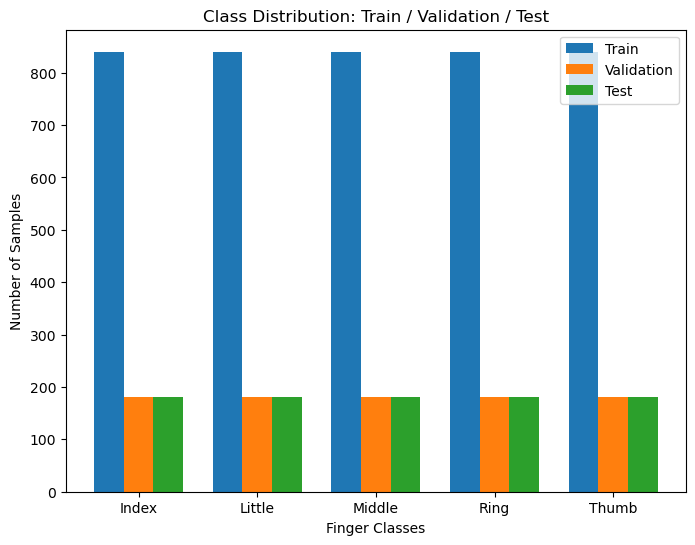

In [2]:
# Plot class distribution
plot_class_distribution(pipeline.y_train, pipeline.y_val, pipeline.y_test)


Classification Report:
              precision    recall  f1-score   support

       Index       0.77      0.84      0.80       180
      Little       0.84      0.70      0.76       180
      Middle       0.72      0.70      0.71       180
        Ring       0.67      0.73      0.70       180
       Thumb       0.95      0.94      0.95       180

    accuracy                           0.78       900
   macro avg       0.79      0.78      0.78       900
weighted avg       0.79      0.78      0.78       900



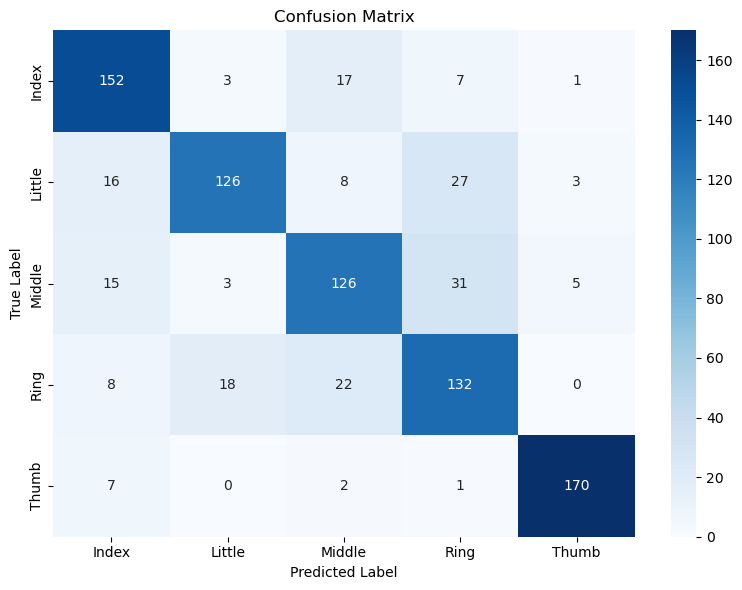

In [3]:
# Plot confusion matrix & classification report
plot_confusion_matrix_and_report(pipeline, normalize=None, save_path='confusion_matrix.png')

In [5]:
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import kornia                      # already installed
from torchvision import transforms # reuse the eval_transform

# ──────────────────────────────────────────────────────────────────────────
def single_image_inference_with_visuals(pipeline, image_path):
    """
    • Shows original ↔︎ edge‑map side‑by‑side.
    • Runs the EfficientNet‑edge model and prints class probabilities.
    Works with the CURRENT pipeline (no external feature_extractor).
    """
    # ------------------------------------------------ load image
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"❌  Could not read image: {image_path}")
        return None, None

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # ------------------------------------------------ build edge map for display
    img_t_edge = transforms.ToTensor()(cv2.resize(img_rgb, (224, 224))).unsqueeze(0).to(device)
    gray       = kornia.color.rgb_to_grayscale(img_t_edge)
    blur       = kornia.filters.gaussian_blur2d(gray, (5,5), (1.0,1.0))
    sobel      = kornia.filters.sobel(blur)
    edge_map   = torch.sqrt((sobel**2).sum(dim=1, keepdim=True))[0,0].cpu().numpy()

    # ------------------------------------------------ model inference
    input_tensor = eval_transform(img_rgb).unsqueeze(0).to(device)   # [1,3,224,224]
    trainer      = pipeline.model_trainer
    trainer.model.eval()
    with torch.no_grad():
        logits = trainer.model(input_tensor)                         # [1,num_classes]
        probs  = torch.softmax(logits, dim=1)[0].cpu().numpy()       # [num_classes]

    idx          = int(probs.argmax())
    pred_label   = trainer.idx_to_label[idx]
    class_labels = [trainer.idx_to_label[i] for i in range(len(probs))]
    prob_dict    = {lbl: float(p) for lbl, p in zip(class_labels, probs)}

    # ------------------------------------------------ side‑by‑side display
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.imshow(img_rgb);  plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(edge_map, cmap="gray"); plt.title("Edge map"); plt.axis("off")
    plt.suptitle(f"Predicted: {pred_label}", fontsize=14)
    plt.show()

    # ------------------------------------------------ console print‑out
    print("Probabilities:")
    for cls, pr in prob_dict.items():
        print(f"  {cls:<7}: {pr:.4f}")

    return pred_label, prob_dict
# ──────────────────────────────────────────────────────────────────────────


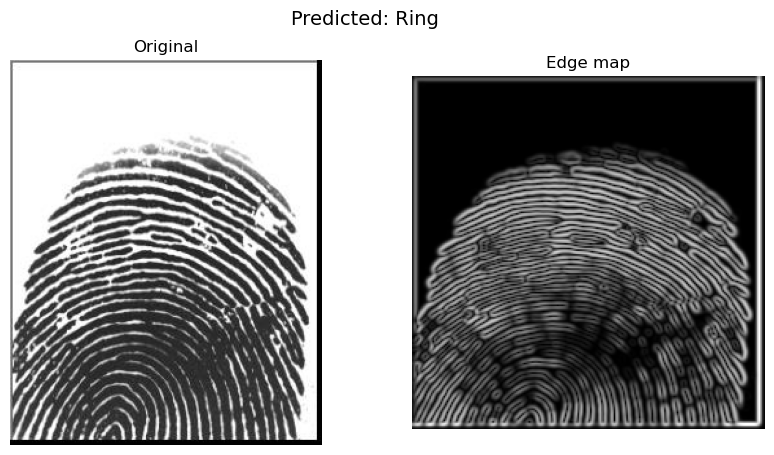

Probabilities:
  Index  : 0.0420
  Little : 0.0055
  Middle : 0.0560
  Ring   : 0.8939
  Thumb  : 0.0026
Predicted label = Ring
Probabilities  = {'Index': 0.04203854873776436, 'Little': 0.005506225395947695, 'Middle': 0.05595984682440758, 'Ring': 0.8938782215118408, 'Thumb': 0.0026171745266765356}


In [6]:
test_img = os.path.expanduser(
    "~/data/SOCOFing/Real/270__M_Left_ring_finger.BMP")

label, probs = single_image_inference_with_visuals(pipeline, test_img)

print("Predicted label =", label)        # show the label in console
print("Probabilities  =", probs)         # full probability dict


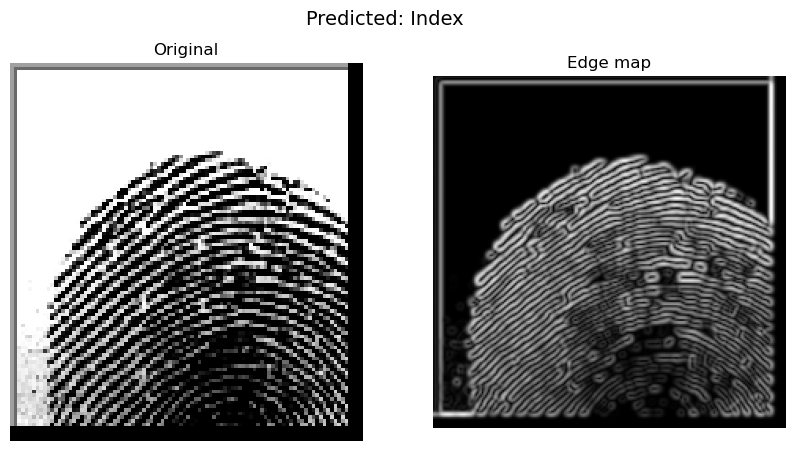

Probabilities:
  Index  : 0.5383
  Little : 0.0006
  Middle : 0.3045
  Ring   : 0.1558
  Thumb  : 0.0008
Predicted label = Index
Probabilities  = {'Index': 0.5383347272872925, 'Little': 0.0005959460395388305, 'Middle': 0.3044717609882355, 'Ring': 0.15581479668617249, 'Thumb': 0.0007828596862964332}


In [7]:
test_img = os.path.expanduser(
    "~/data/SOCOFing/Real/281__M_Left_index_finger.BMP")

label, probs = single_image_inference_with_visuals(pipeline, test_img)

print("Predicted label =", label)        # show the label in console
print("Probabilities  =", probs)         # full probability dict


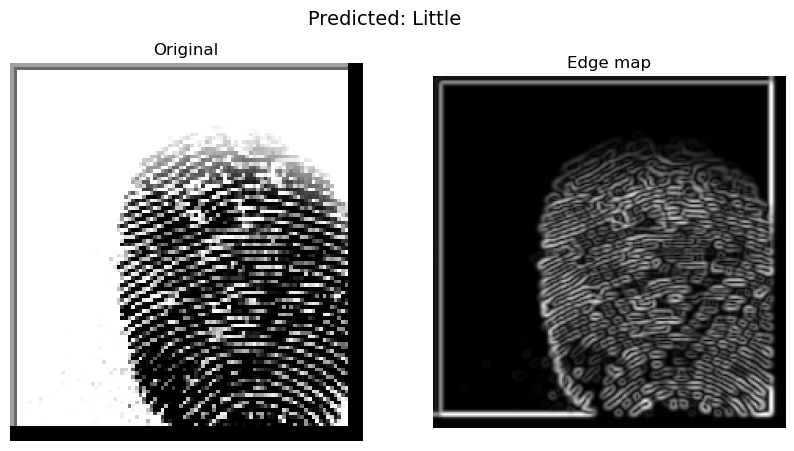

Probabilities:
  Index  : 0.0039
  Little : 0.9940
  Middle : 0.0001
  Ring   : 0.0019
  Thumb  : 0.0001
Predicted label = Little
Probabilities  = {'Index': 0.003916711546480656, 'Little': 0.9940383434295654, 'Middle': 8.204136247513816e-05, 'Ring': 0.001882245298475027, 'Thumb': 8.0728845205158e-05}


In [8]:
test_img = os.path.expanduser(
    "~/data/SOCOFing/Real/45__M_Right_little_finger.BMP")

label, probs = single_image_inference_with_visuals(pipeline, test_img)

print("Predicted label =", label)        # show the label in console
print("Probabilities  =", probs)         # full probability dict


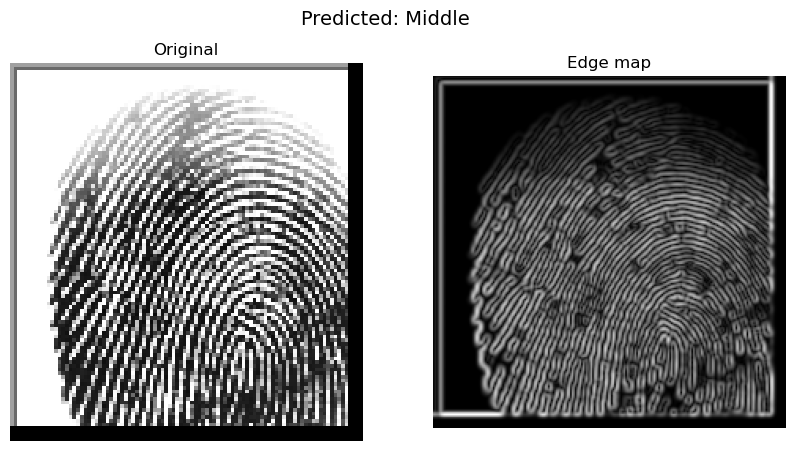

Probabilities:
  Index  : 0.0005
  Little : 0.0012
  Middle : 0.9904
  Ring   : 0.0078
  Thumb  : 0.0000
Predicted label = Middle
Probabilities  = {'Index': 0.0005419143126346171, 'Little': 0.0012368131428956985, 'Middle': 0.9903624653816223, 'Ring': 0.007846868596971035, 'Thumb': 1.1914619790331926e-05}


In [9]:
test_img = os.path.expanduser(
    "~/data/SOCOFing/Real/279__M_Left_middle_finger.BMP")

label, probs = single_image_inference_with_visuals(pipeline, test_img)

print("Predicted label =", label)        # show the label in console
print("Probabilities  =", probs)         # full probability dict


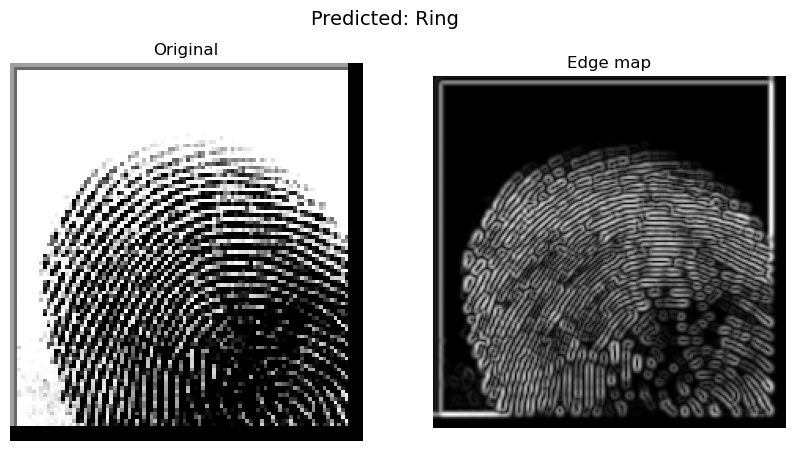

Probabilities:
  Index  : 0.0001
  Little : 0.0005
  Middle : 0.0003
  Ring   : 0.9991
  Thumb  : 0.0000
Predicted label = Ring
Probabilities  = {'Index': 6.621830107178539e-05, 'Little': 0.0005050567560829222, 'Middle': 0.0002829524455592036, 'Ring': 0.9991183876991272, 'Thumb': 2.7464462618809193e-05}


In [10]:
test_img = os.path.expanduser(
    "~/data/SOCOFing/Real/98__M_Right_ring_finger.BMP")

label, probs = single_image_inference_with_visuals(pipeline, test_img)

print("Predicted label =", label)        # show the label in console
print("Probabilities  =", probs)         # full probability dict


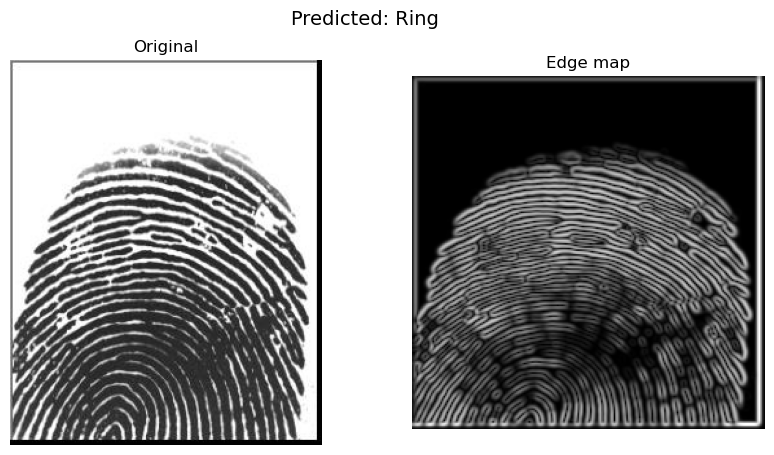

Probabilities:
  Index  : 0.0420
  Little : 0.0055
  Middle : 0.0560
  Ring   : 0.8939
  Thumb  : 0.0026


In [11]:
test_img = os.path.expanduser("~/data/SOCOFing/Real/270__M_Left_ring_finger.BMP")
pred, probs = single_image_inference_with_visuals(pipeline, test_img)